In [1]:
from neo4j import GraphDatabase

url = "bolt://localhost:7687"
username = "neo4j"
password = "letmein"

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [2]:
import pandas as pd

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [ ]:
# Create feature set
# Take 90% of existing rels
run_query("""
MATCH (s1:Stream)-[:SHARED_AUDIENCE]->(s2:Stream)
WITH totalCount, s1, s2
ORDER BY s1.id,s2.id

WITH totalCount, collect([s1,s2]) AS rels

WITH rels[..toInteger(totalCount * 0.9)] AS feature_rels
UNWIND feature_rels AS pair
WITH pair[0] AS node1, pair[1] AS node2
MERGE (node1)-[:FEATURE_REL]->(node2);""")

In [ ]:
# Create test/train rel
# Take the remaining 10%
run_query("""
MATCH (s1)-[:SHARED_AUDIENCE]->(s2)
WHERE NOT (s1)-[:FEATURE_REL]->(s2)
MERGE (s1)-[:TEST_TRAIN]->(s2);
""")

In [ ]:
# Create negative test/train pairs
run_query("""
MATCH (s1:Stream),(s2:Stream)
WHERE NOT (s1)-[:SHARED_AUDIENCE]-(s2)
WITH s1,s2
LIMIT 13143
MERGE (s1)-[:NEGATIVE_TEST_TRAIN]->(s2);
""")

# Create features

In [13]:
# Create features for test/train set based on Feature set
data = run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WHERE NOT s1 = s2
WITH s1,s2, length(shortestPath((s1)-[:FEATURE_REL*..7]-(s2))) AS networkDistance,
            size((s1)-[:FEATURE_REL]-()) * size((s2)-[:FEATURE_REL]-()) AS  preferentialAttachment,
            CASE WHEN r:TEST_TRAIN THEN 1 ELSE 0 END as output
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH s1,s2, networkDistance, preferentialAttachment, output, count(distinct neighbor) AS commonNeighbor
RETURN networkDistance, preferentialAttachment, commonNeighbor, output     
""")

In [14]:
data.head()

,networkDistance,preferentialAttachment,commonNeighbor,output
0,2.0,22932,13,0
1,2.0,11466,1,0
2,2.0,9009,9,0
3,2.0,18018,17,0
4,3.0,819,0,0


In [20]:
missing_values = data[data.isnull().any(axis=1)]

print(f"There are {len(missing_values)} rows with NaN values")
print(missing_values.head())

There are 120 rows with NaN values
     networkDistance  preferentialAttachment  commonNeighbor  output
157              NaN                       0               0       0
330              NaN                     819               0       0
366              NaN                       0               0       0
473              NaN                       0               0       0
582              NaN                     819               0       0


In [22]:
data['networkDistance'] = data['networkDistance'].fillna(7)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data[["networkDistance", "preferentialAttachment", "commonNeighbor"]].values
y = data["output"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2612
           1       0.88      0.87      0.87      2642

    accuracy                           0.87      5254
   macro avg       0.87      0.87      0.87      5254
weighted avg       0.87      0.87      0.87      5254



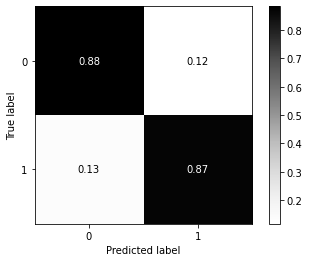

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", cmap="Greys")